# Model Explainability

## Imports

In [1]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import shap
import sklearn
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib

## Loading Data and Model

The model is explained in the other jupyter notebook. The code is copied here.

### Loading Data

In [2]:
data_path = './data/medical_costs/insurance.csv'
raw_data = pd.read_csv(data_path)

data = raw_data.copy(deep=True)
# make smoker and sex binary
data['is_smoker'] = (data['smoker'] == 'yes').astype(int)
data['is_male'] = (data['sex'] == 'male').astype(int)

# make regions 1hot
regions = list(data['region'].unique())
for region in regions:
    data[region] = (data['region'] == region).astype(int)
    
# drop the old columns
data.drop(
    labels=['sex', 'smoker', 'region'],
    axis=1,
    inplace=True
)

# reorder columns
new_col_order = ['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 
                 'southeast', 'northwest', 'northeast', 'expenses']
data = data[new_col_order]

In [3]:
train, test_val = sklearn.model_selection.train_test_split(
    data, 
    test_size=0.4, 
    random_state=21, 
    shuffle=True
)
val, test = sklearn.model_selection.train_test_split(
    test_val, 
    test_size=0.5, 
    random_state=21, 
    shuffle=True
)

# normalize the X data with a standard scaler.
standard_scaler = StandardScaler()

X_train = train[['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 
                  'southeast', 'northwest', 'northeast']]
X_val = val[['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 
                  'southeast', 'northwest', 'northeast']]
X_test = test[['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 
                  'southeast', 'northwest', 'northeast']]
y_train = train[['expenses']].to_numpy()
y_val = val[['expenses']].to_numpy()
y_test = test[['expenses']].to_numpy()


standard_scaler.fit(X_train.to_numpy())

#X_train_normed = standard_scaler.transform(X_train)
#X_val_normed = standard_scaler.transform(X_val)
#X_test_normed = standard_scaler.transform(X_test)

# norming in the model
"""train_normed = np.concatenate((X_train_normed, y_train), axis=1)
val_normed = np.concatenate((X_val_normed, y_val), axis=1)
test_normed = np.concatenate((X_test_normed, y_test), axis=1)"""

train_normed = train.to_numpy()
val_normed = val.to_numpy()
test_normed = test.to_numpy()

In [4]:
class health_cost_dataset(Dataset):
    def __init__(self, data, transform=None):
        # data should be numpy array of shape (-1, 10)
        self.data = data.astype('float32')
        self.transform = transform
        self.length = len(data)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        item = self.data[index]
        if self.transform:
            item = transform(item)
        X = item[:9]
        y = item[9:]
        return X, y

In [5]:
class health_cost_net(nn.Module):
    def __init__(self, hidden_layers=[]):
        super(health_cost_net, self).__init__()
        
        hiddens = hidden_layers.copy()
        self.input_size = 9
        self.output_size = 1
        hiddens.insert(0, self.input_size)
        hiddens.append(self.output_size)
        
        self.layers = nn.ModuleList()
        for k in range(len(hiddens)-1):
            self.layers.append(nn.Linear(hiddens[k], hiddens[k+1]))
            if k < len(hiddens)-2:
                self.layers.append(nn.ReLU())
        # final node output is predicted continuous output
        
    def forward(self, x):
        for f in self.layers:
            x = f(x)
        return x

def train(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    model = model.float()
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        #X = torch.Tensor(standard_scaler.transform(X))
        X, y = X.to(device), y.to(device)
        
        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 50 == 0 and verbose:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

def test(dataloader, model, loss_fn, verbose=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model = model.float()
    model.eval()
    
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            #X = torch.Tensor(standard_scaler.transform(X))
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    if verbose:
        print(f"Results: \n Avg loss: {test_loss:>4f}")
    return  test_loss
    

In [6]:
train_dataset = health_cost_dataset(train_normed)
val_dataset = health_cost_dataset(val_normed)
test_dataset = health_cost_dataset(test_normed)

torch.manual_seed(0)

batch_size = 200

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = health_cost_net(hidden_layers= [8, 6, 4])
model = model.float()

# regression, typical choice is MSE
loss_fn = nn.MSELoss()

# adam is popular due to its grad boosting capabilities, 
#  and it includes momentum and weight punishing
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.1, 
    betas=(0.9, 0.999), 
    eps=1e-8, 
    weight_decay=0.001
)

train_loss = []
val_loss = []

#epochs = 86
epochs = 201
for t in range(epochs):
    train_l = train(train_dataloader, model, loss_fn, optimizer, verbose=False)
    train_loss.append(train_l.detach().numpy())
    
    val_l = test(val_dataloader, model, loss_fn, verbose=False)
    val_loss.append(val_l)

    
print("Done training!")
print(f"End Loss:  {val_loss[-1]:>4f}")


Using cpu device
Done training!
End Loss:  43321792.000000


In [7]:
def get_all_preds(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model = model.float()
    model.eval()
    
    all_preds, actual = [], []
    with torch.no_grad():
        for X, y in dataloader:
            #X = torch.Tensor(standard_scaler.transform(X))

            X, y = X.to(device), y.to(device)
            pred = model(X)
            all_preds.append(pred)
            actual.append(y)
    
    p = torch.vstack(all_preds)
    a = torch.vstack(actual)
    return  p, a

In [8]:
p, y = get_all_preds(test_dataloader, model)

In [9]:
## use all train set to develop shap vals
## Get shap vals for some fake people
## make the fancy plot
## have it show how your risk differs from the average

## Model Explainability with SHAP

Shap explainability adapts a game theory contributions strategy to ML where each feature gets assigned a value that represents its impact on the outcome relative to the expected value of the outcome. In other words, how does a feature change the outcome from the average outcome.

**Links:**
[SHAP library](https://shap.readthedocs.io/en/latest/#)

[SHAP paper](https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html)


### Explaining one outcome compared to the average outcome

In [83]:
# we need to define a function that makes predictions. This function just formats the input and returns the model output
def f(X):
    #print(X)
    #print(type(X))
    if type(X) == pd.DataFrame:
        X = X.to_numpy()
    X = torch.Tensor(X)
    return model(X)

In [84]:
# the explainer needs to have observations of the model's behavior
X = train_dataset.data[:, :9]
df = pd.DataFrame(X)

In [85]:
# create the shap explainer
explainer = shap.Explainer(f, df)

In [117]:
persona_age = 44
persona_sex = 1
persona_bmi = 25
persona_child = 2
persona_smoke = 1
persona_sw = 1
persona_se = 0
persona_nw = 0
persona_me = 0
p = np.array([persona_age, persona_sex, persona_bmi, persona_child, persona_smoke, persona_sw, persona_se, persona_nw, persona_me]).reshape((1, 9))

In [118]:
# use the explainer to get explainations for 2 observations
sv = explainer(p)

In [119]:
# use the explaination to make an explaination object
exp = shap.Explanation(sv.values, sv.base_values[0][0], sv.data, feature_names=['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 
                 'southeast', 'northwest', 'northeast'])

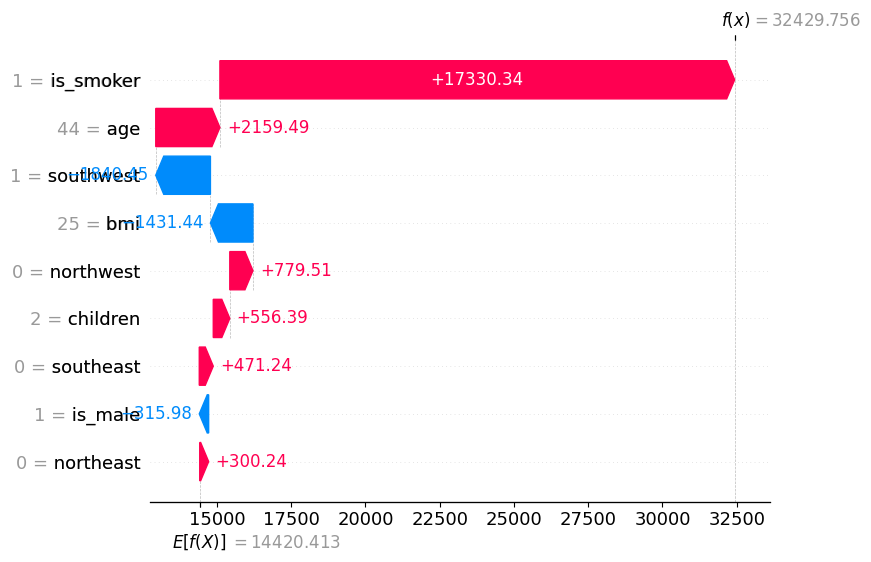

In [120]:
# use that object in a visualization
shap.plots.waterfall(exp[0])

This visualization starts at the bottom with the model's anticipated output for the average person. In order of increasing impact on the prediction, the impact of various features is shown. The impact of having one child is an increase of 21 compared to the average person. Being 26 years old decreases cost by 1900.

### Explaining the whole model

Visualization of the whole model's reasons for explanation. This output shows the impact of variables on the model's output. The color scale shows the feature value, and the x axis shows the impact of the model's explanation.




In [100]:
sv_2 = explainer(df)

In [101]:
exp_2 = shap.Explanation(sv_2.values, sv_2.base_values[0][0], sv_2.data, feature_names=['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 
                 'southeast', 'northwest', 'northeast'])

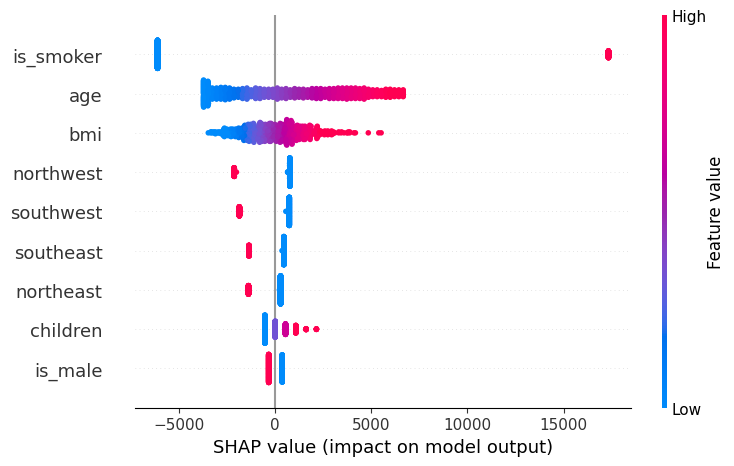

In [102]:
shap.plots.beeswarm(exp_2)

**The force plot** shows the factors that increase a model's output on the left and the features that decrease a model's output on the right. This visualization helps explain the factors that make one prediction.

In [103]:
shap.initjs()

In [121]:
shap.plots.force(exp[0])

### Explaing model output as a comparison

In [37]:
# set up the background
bg_age = 39  # average
bg_is_male = 0  # as world pop has more women
bg_bmi = 31  # average
bg_children = 1  # average
bg_is_smoker = 0  # average
bg_southwest = 0  # most popular region
bg_southeast = 1
bg_northwest = 0
bg_northeast = 0

In [38]:
x_data = data[['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 'southeast', 'northwest', 'northeast']]

In [39]:
bg = x_data[
#    (x_data['age'] == bg_age) &
    (x_data['is_male'] == bg_is_male) &
#    (x_data['bmi'] == bg_bmi) &
    (x_data['children'] == bg_children) &
    (x_data['is_smoker'] == bg_is_smoker) &
    (x_data['southwest'] == bg_southwest) &
    (x_data['southeast'] == bg_southeast) &
    (x_data['northwest'] == bg_northwest) &
    (x_data['northeast'] == bg_northeast)
      ]
#bg

In [40]:
explainer = shap.Explainer(f, bg)

In [41]:
# ['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 'southeast', 'northwest', 'northeast']
persona_age = 22
persona_sex = 1
persona_bmi = 39
persona_child = 0
persona_smoke = 0
persona_sw = 0
persona_se = 0
persona_nw = 0
persona_me = 1
p = np.array([persona_age, persona_sex, persona_bmi, persona_child, persona_smoke, persona_sw, persona_se, persona_nw, persona_me]).reshape((1, 9))

In [42]:
sv = explainer(p)

In [43]:
exp = shap.Explanation(sv.values, sv.base_values[0][0], sv.data, feature_names=['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 
                 'southeast', 'northwest', 'northeast'])

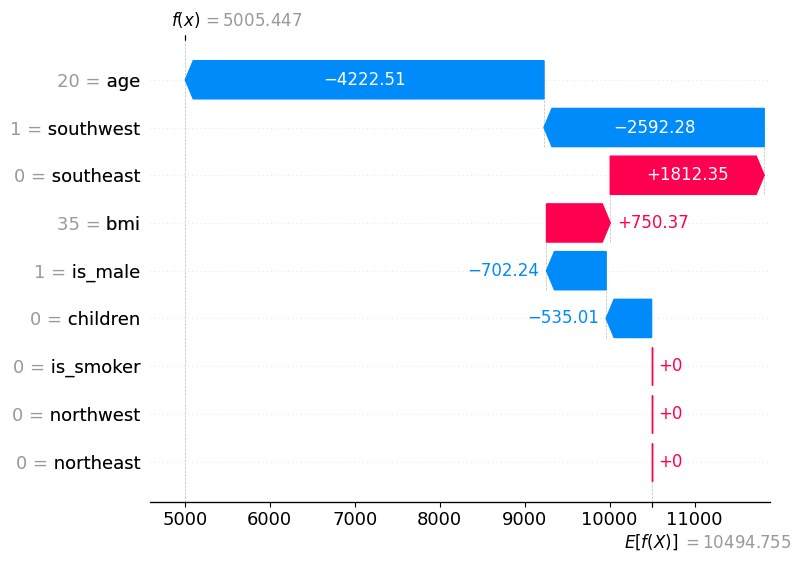

In [44]:
shap.plots.waterfall(exp[0])

In this example, we changed the background to be a certain person, a 39 year old woman from the southeast. The shap values are then calculated for a 20 year old male. 

The background comparison tells us, "compared to people like A, person B's model output differs for these reasons...." We see that the age of person B works in their favor, while not being from the southeast harms them.
